# **Exploracion de datos de titanic**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/S7/IA_DP/titanic"
!ls

/content/gdrive/MyDrive/S7/IA_DP/titanic
gender_submission.csv  submission-manual-cleansing.csv	train.csv
submission.csv	       test.csv


## Extraccion


### Library Imports

In [ ]:
# Install keras
!sudo pip3 install keras
!sudo pip3 install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats.distributions as dist
import os
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Lectura de datos

In [ ]:
if(os.path.isfile('train.csv')):
  train_df = pd.read_csv('train.csv')
test_data_kaggle = pd.read_csv('test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Util Funcs


In [ ]:
def prep_data(df):
  # Creating dummy variables for sex
  dummies_sex = df_encoder.fit_transform(df[['Sex']])
  df[['Female', 'Male']] = pd.DataFrame(dummies_sex.toarray())
  # Creating dummy variables for embarked
  dummies_embarked = df_encoder.fit_transform(df[['Embarked']])
  df = df.join(pd.DataFrame(dummies_embarked.toarray(), columns = df_encoder.get_feature_names_out(['Embarked'])))
  # Replace Fare values equal to 0 by np.nan if any
  df['Fare'] = df['Fare'].replace(0, np.nan)
  # Fill NaN Fare values with median
  df['Fare'] = df.groupby(['Pclass', 'Sex'])['Fare'].fillna(df['Fare'].median())
  # Getting Missing Age Values using Linear Regression
  df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked'], axis = 1)
  lin_regress_df = df.copy(deep=True)
  # We can use max_iter=20 to set a # of cycles
  cols = [col for col in df.columns if df[col].dtype != object]
  imputer = IterativeImputer(random_state=42)
  # numbers_only_df = train_df.select_dtypes(include=[np.number])
  imputed = imputer.fit_transform(lin_regress_df)
  iterative_df = pd.DataFrame(imputed, columns=cols)
  iterative_df.head()
  print(iterative_df)
  print(iterative_df['Age'].isnull().sum())
  print(train_df['Age'].isnull().sum())
  iterative_df['Age'] = iterative_df['Age'].round()

  # Scaling features
  scaler = MinMaxScaler()
  pre_scale_df = iterative_df.copy(deep=True)
  scaler.fit(pre_scale_df)
  iterative_df = scaler.fit_transform(pre_scale_df)

  return iterative_df

### Exploracion inicial de los datos

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


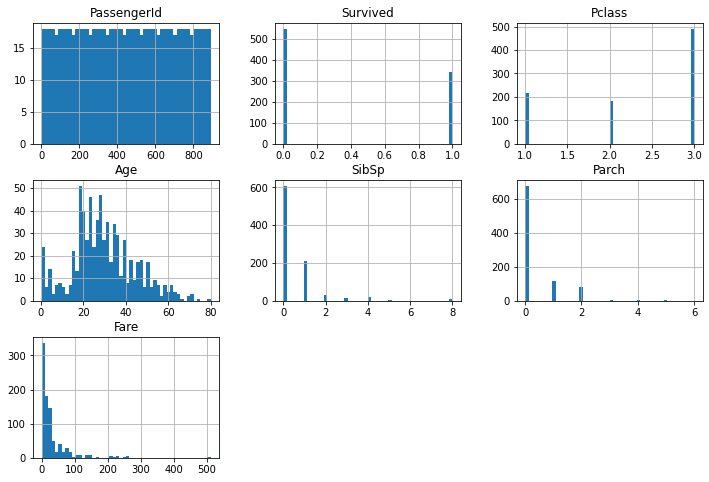

In [ ]:
train_df.hist(bins=50, figsize=(12, 8))
plt.show()

Text(0.5, 1.0, 'Correlation matrix for the titanic dataset')

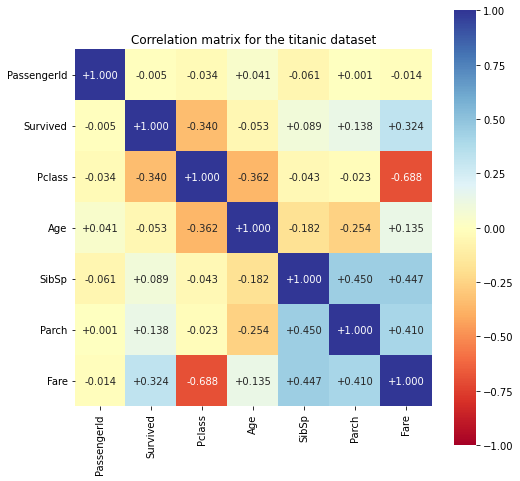

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(train_df.corr(method='spearman'), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.3f")
plt.title("Correlation matrix for the titanic dataset")

Utilizamos el mapa para poder visualizar la correlacion de las variables utilizando el metodo spearman

Despues de ver el mapa, note unas correlaciones que me parecieron importantes.<br />
Durante mi analisis tuve la teoria de que las mujeres llevarian prioridad a la hora de evacuar asi que ahora hay que ver los datos crudos <br />
**TEORIA: La supervivencia de mujeres sera mayor que la de los hombres debido a que llevan posiblemente prioridad en la evacuacion**
Procedere inicialmente a hacer el conteo de supervivencias y muertes separandolo por sexo

In [ ]:
survived_sex_df = pd.crosstab(train_df.Survived,train_df.Sex)
survived_sex_df.head()

Sex,female,male
Survived,,
0,81,468
1,233,109


Podemos ver los numeros y vemos que una mayor cantidad de mujeres sobrevivio. Esto podria confirmar la teoria inicial<br />
Ahora para verlo un poco mejor en proporcion...

In [ ]:
survived_sex_proportion_df = pd.crosstab(train_df.Survived,train_df.Sex).apply(lambda x:x/x.sum(),axis=0)
survived_sex_proportion_df.head()

Sex,female,male
Survived,,
0,0.257962,0.811092
1,0.742038,0.188908


Podemos notar que un mucho mayor porcentaje de mujeres sobrevivio en comparacion a los hombres.

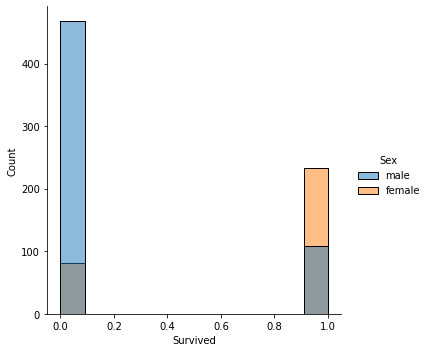

In [ ]:
sns.displot(train_df, x="Survived", hue="Sex")

Ahora me interesaria graficar la supervivencia debido a la clase a la que pertenecian las personas

In [ ]:
survived_class_df = pd.crosstab(train_df.Survived, train_df.Pclass)
survived_class_df.head()

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


Aqui claramente podemos ver que la primera clase fue la que tuvo el mayor numero de supervivencias mientras que la tercera clase fue la que tuvo mas muertes, la cual nos puede decir 2 cosas... <br />
Primera: La primera clase tiene mas probabilidades de morir... <br />
Segunda: Teniamos una mayor cantidad de tercera clase abordo del titanic.

In [ ]:
survived_class_df = pd.crosstab(train_df.Survived, train_df.Pclass).apply(lambda x:x/x.sum(),axis=0)
survived_class_df.head()

Pclass,1,2,3
Survived,,,
0,0.37037,0.527174,0.757637
1,0.62963,0.472826,0.242363


Nuevamente lo visualizamos en proporciones...

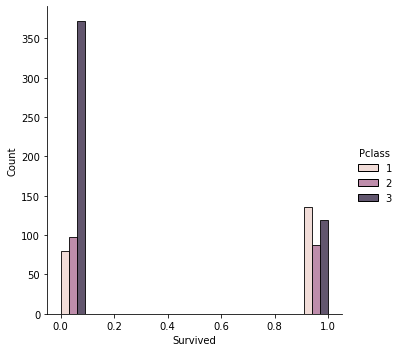

In [ ]:
sns.displot(train_df, x="Survived", hue="Pclass", multiple="dodge")

## Limpieza de datos


### Estrategia
Se va a remover el PassengerId ya que es unicamente una variable de identificacion y no se considera necesaria para el modelo. <br/>
Se va a remover el Name ya que no se considera como un dato relevante para la supervivencia de la persona. <br/>
Se va a remover el Ticket ya que no pensamos que tenga algun significado o correlacion con la supervivencia. <br/>
Se va remover la Cabin ya que contiene muchos datos vacios y se considera que la variable Pclass tiene un peso mayor que Cabin siendo que Pclass se relaciona a Cabin.


## **Fase de transformacion**

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [ ]:
# Importamos OneHotEncoder la cual nos obtendra nuestras sparse matrix para nuestras variables dummy
df_encoder = OneHotEncoder()
df_encoder.handle_unknown = "ignore"

### **Dummy Variables Encoding for Sex and Embarked Strat**

In [ ]:
print('Null embarked values: ', train_df['Embarked'].isnull().sum())
print('Null sex values: ', train_df['Sex'].isnull().sum())
print('Null fare values: ', train_df['Fare'].isnull().sum())
print((train_df['Fare'] == 0).sum())

Null embarked values:  2
Null sex values:  0
Null fare values:  0
15


In [ ]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Filtering manually in the df for NaN values in Embarked lead us to two persons. Looking for Martha Stone Titanic lead us to this encyclopedia, reading at her story we end up getting from which port she embarked from.
We also can search for Amelie Icard which is actually Mrs Martha Stone maid. They ended up abording the titanic together and survived together. <br/>
**FACT:** When Mrs Martha Stone passed away she ended up giving a large sum of cash and other possesions to Amelie Icard.
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

In [ ]:
# Filling embarked missing values...
train_df['Embarked'] = train_df['Embarked'].fillna('S')

Getting dummy variables for Sex...

In [ ]:
dummies_sex = df_encoder.fit_transform(train_df[['Sex']])
train_df[['Female', 'Male']] = pd.DataFrame(dummies_sex.toarray())
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0


In [ ]:
dummies_embarked = df_encoder.fit_transform(train_df[['Embarked']])
train_df = train_df.join(pd.DataFrame(dummies_embarked.toarray(), columns = df_encoder.get_feature_names_out(['Embarked'])))
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0


In [ ]:
# Replace Fare values equal to 0 by np.nan
train_df['Fare'] = train_df['Fare'].replace(0, np.nan)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0,1.0,0.0,0.0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,0.0,0.0,0.0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1.0,0.0,0.0,0.0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0,1.0,1.0,0.0,0.0


In [ ]:
# Fill NaN Fare values with median
train_df['Fare'] = train_df.groupby(['Pclass', 'Sex'])['Fare'].fillna(train_df['Fare'].median())
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0,1.0,0.0,0.0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,0.0,0.0,0.0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1.0,0.0,0.0,0.0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0,1.0,1.0,0.0,0.0


### Transformacion de Edad

In [ ]:
del train_df["PassengerId"]
del train_df["Name"]
del train_df["Ticket"]
del train_df["Cabin"]

In [ ]:
train_df = train_df.drop('Embarked', axis=1)
train_df = train_df.drop('Sex', axis=1)
# train_df = train_df.drop('Title', axis=1)

En esta transformacion se esta haciendo una regresion lineal con todas las caracteristicas **NUMERICAS**. Se usa la funcion de IterativeImputer la cual nos asegurara transformaciones consistentes ya en produccion.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
print(train_df['Age'].isnull().sum())
lin_regress_df = train_df.copy(deep=True)
# We can use max_iter=20 to set a # of cycles
cols = [col for col in train_df.columns if train_df[col].dtype != object]
imputer = IterativeImputer(random_state=42)
# numbers_only_df = train_df.select_dtypes(include=[np.number])
imputed = imputer.fit_transform(lin_regress_df)
iterative_df = pd.DataFrame(imputed, columns=cols)
iterative_df.head()
print(iterative_df)
print(iterative_df['Age'].isnull().sum())
print(train_df['Age'].isnull().sum())
iterative_df['Age'] = iterative_df['Age'].round()
# IterativeImputer

177
     Survived  Pclass       Age  SibSp  Parch     Fare  Female  Male  \
0         0.0     3.0  22.00000    1.0    0.0   7.2500     0.0   1.0   
1         1.0     1.0  38.00000    1.0    0.0  71.2833     1.0   0.0   
2         1.0     3.0  26.00000    0.0    0.0   7.9250     1.0   0.0   
3         1.0     1.0  35.00000    1.0    0.0  53.1000     1.0   0.0   
4         0.0     3.0  35.00000    0.0    0.0   8.0500     0.0   1.0   
..        ...     ...       ...    ...    ...      ...     ...   ...   
886       0.0     2.0  27.00000    0.0    0.0  13.0000     0.0   1.0   
887       1.0     1.0  19.00000    0.0    0.0  30.0000     1.0   0.0   
888       0.0     3.0  23.19067    1.0    2.0  23.4500     1.0   0.0   
889       1.0     1.0  26.00000    0.0    0.0  30.0000     0.0   1.0   
890       0.0     3.0  32.00000    0.0    0.0   7.7500     0.0   1.0   

     Embarked_C  Embarked_Q  Embarked_S  
0           0.0         0.0         1.0  
1           1.0         0.0         0.0  
2    

In [ ]:
iterative_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Female,Male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0


In [ ]:
x_data, y_data = iterative_df.loc[:, iterative_df.columns != 'Survived'], iterative_df['Survived']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
pre_scale_df = x_data.copy(deep=True)
scaler.fit(pre_scale_df)
x_data = pd.DataFrame(scaler.fit_transform(pre_scale_df), columns = pre_scale_df.columns, index = pre_scale_df.index)

In [ ]:
x_data.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.317647,0.125,0.0,0.006369,0.0,1.0,0.0,0.0,1.0
1,0.0,0.505882,0.125,0.0,0.132340,1.0,0.0,1.0,0.0,0.0
2,1.0,0.364706,0.000,0.0,0.007697,1.0,0.0,0.0,0.0,1.0
3,0.0,0.470588,0.125,0.0,0.096569,1.0,0.0,0.0,0.0,1.0
4,1.0,0.470588,0.000,0.0,0.007943,0.0,1.0,0.0,0.0,1.0


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_test_copy = iterative_df.copy(deep=True)

In [ ]:
x_test_copy

,Survived,Pclass,Age,SibSp,Parch,Fare,Female,Male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,27.0,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,1.0
887,1.0,1.0,19.0,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0
888,0.0,3.0,23.0,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0
889,1.0,1.0,26.0,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0


# Modelado

## Estrategias

### Estrategia 2: Logistic Regression
It seems this model is good for classifying data belonging to categories, particularly [1,0] binary decisions

In [ ]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
%load_ext google.colab.data_table
x_test

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Female,Male
709,1.0,3.0,16.0,1.0,1.0,15.2458,1.0,0.0,0.0,0.0,1.0
439,0.0,2.0,31.0,0.0,0.0,10.5000,0.0,0.0,1.0,0.0,1.0
840,0.0,3.0,20.0,0.0,0.0,7.9250,0.0,0.0,1.0,0.0,1.0
720,1.0,2.0,6.0,0.0,1.0,33.0000,0.0,0.0,1.0,1.0,0.0
39,1.0,3.0,14.0,1.0,0.0,11.2417,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
433,0.0,3.0,17.0,0.0,0.0,7.1250,0.0,0.0,1.0,0.0,1.0
773,0.0,3.0,28.0,0.0,0.0,7.2250,1.0,0.0,0.0,0.0,1.0
25,1.0,3.0,38.0,1.0,5.0,31.3875,0.0,0.0,1.0,1.0,0.0
84,1.0,2.0,17.0,0.0,0.0,10.5000,0.0,0.0,1.0,1.0,0.0


In [ ]:
x_test = x_test.drop('Survived', axis=1)

In [ ]:
y_pred = logr.predict(x_test)
x_test['y_pred'] = y_pred

In [ ]:
x_test

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Female,Male,y_pred
709,3.0,16.0,1.0,1.0,15.2458,1.0,0.0,0.0,0.0,1.0,0.0
439,2.0,31.0,0.0,0.0,10.5000,0.0,0.0,1.0,0.0,1.0,0.0
840,3.0,20.0,0.0,0.0,7.9250,0.0,0.0,1.0,0.0,1.0,0.0
720,2.0,6.0,0.0,1.0,33.0000,0.0,0.0,1.0,1.0,0.0,1.0
39,3.0,14.0,1.0,0.0,11.2417,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
433,3.0,17.0,0.0,0.0,7.1250,0.0,0.0,1.0,0.0,1.0,0.0
773,3.0,28.0,0.0,0.0,7.2250,1.0,0.0,0.0,0.0,1.0,0.0
25,3.0,38.0,1.0,5.0,31.3875,0.0,0.0,1.0,1.0,0.0,0.0
84,2.0,17.0,0.0,0.0,10.5000,0.0,0.0,1.0,1.0,0.0,1.0


In [ ]:
clean_test_data = prep_data(test_data_kaggle)
predictionsl = (logr.predict(clean_test_data)).astype(int)

     Pclass        Age  SibSp  Parch      Fare  Female  Male  Embarked_C  \
0       3.0  34.500000    0.0    0.0    7.8292     0.0   1.0         0.0   
1       3.0  47.000000    1.0    0.0    7.0000     1.0   0.0         0.0   
2       2.0  62.000000    0.0    0.0    9.6875     0.0   1.0         0.0   
3       3.0  27.000000    0.0    0.0    8.6625     0.0   1.0         0.0   
4       3.0  22.000000    1.0    1.0   12.2875     1.0   0.0         0.0   
..      ...        ...    ...    ...       ...     ...   ...         ...   
413     3.0  25.010140    0.0    0.0    8.0500     0.0   1.0         0.0   
414     1.0  39.000000    0.0    0.0  108.9000     1.0   0.0         1.0   
415     3.0  38.500000    0.0    0.0    7.2500     0.0   1.0         0.0   
416     3.0  25.010140    0.0    0.0    8.0500     0.0   1.0         0.0   
417     3.0  23.023791    1.0    1.0   22.3583     0.0   1.0         1.0   

     Embarked_Q  Embarked_S  
0           1.0         0.0  
1           0.0         1.0

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Estrategia 2: Performance Measure

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(x_test_copy['Survived'], x_test['y_pred'])
rmse

0.17318435754189945

In [ ]:
from sklearn.metrics import precision_score
ps_macro = precision_score(x_test_copy['Survived'], x_test['y_pred'], average='macro')
ps_micro = precision_score(x_test_copy['Survived'], x_test['y_pred'], average='micro')
ps_weighted = precision_score(x_test_copy['Survived'], x_test['y_pred'], average='weighted')
print(ps_macro)
print(ps_micro)
print(ps_weighted)

0.8239789196310936
0.8268156424581006
0.8261237588417574


# Keras

### Estrategia 5: Keras

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
model = Sequential()
model.add(Dense(10, activation = 'relu', input_shape=(10,)))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Model 0 Sin Optimizar
model = Sequential()
model.add(Dense(20, activation = 'relu', input_shape=(10,)))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Model 1 0.76~
model = Sequential()
model.add(Dense(20, activation = 'relu', input_shape=(10,)))
model.add(Dropout(0.2))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# maybe try sgd

In [ ]:
from keras import regularizers

# Best Model 0.79665
model = Sequential()
model.add(Dense(20, activation = 'relu', input_shape=(10,), kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(40, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(20, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(10, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
from keras import regularizers

# Model 4 0.75 1500 epochs
model = Sequential()
model.add(Dense(10, activation = 'relu', input_shape=(10,), kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(30, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(20, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(2, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = 500, batch_size = 50, validation_data=(x_test, y_test))

Epoch 1/500
15/15 [==============================] - 1s 22ms/step - loss: 0.6917 - accuracy: 0.6601 - val_loss: 0.6892 - val_accuracy: 0.7598
Epoch 2/500
15/15 [==============================] - 0s 7ms/step - loss: 0.6860 - accuracy: 0.7781 - val_loss: 0.6820 - val_accuracy: 0.7821
Epoch 3/500
15/15 [==============================] - 0s 8ms/step - loss: 0.6758 - accuracy: 0.7753 - val_loss: 0.6653 - val_accuracy: 0.7654
Epoch 4/500
15/15 [==============================] - 0s 5ms/step - loss: 0.6575 - accuracy: 0.7795 - val_loss: 0.6418 - val_accuracy: 0.7709
Epoch 5/500
15/15 [==============================] - 0s 6ms/step - loss: 0.6362 - accuracy: 0.7907 - val_loss: 0.6224 - val_accuracy: 0.7821
Epoch 6/500
15/15 [==============================] - 0s 5ms/step - loss: 0.6182 - accuracy: 0.7893 - val_loss: 0.6075 - val_accuracy: 0.7654
Epoch 7/500
15/15 [==============================] - 0s 5ms/step - loss: 0.6024 - accuracy: 0.7879 - val_loss: 0.5941 - val_accuracy: 0.7821
Epoch 8/500


In [ ]:
print("score on test: " + str(model.evaluate(x_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(x_train,y_train)[1]))

6/6 [==============================] - 0s 4ms/step - loss: 0.4410 - accuracy: 0.8045
score on test: 0.8044692873954773
23/23 [==============================] - 0s 2ms/step - loss: 0.3399 - accuracy: 0.8596
score on train: 0.8595505356788635


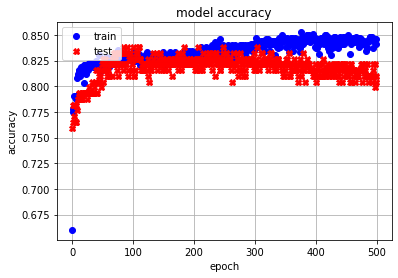

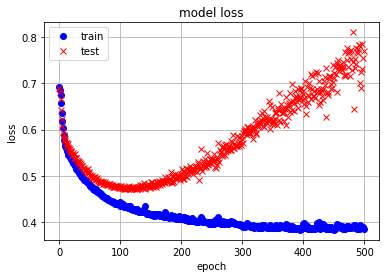

In [ ]:
plt.plot(history.history['accuracy'], 'bo')
plt.plot(history.history['val_accuracy'], 'rX')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.grid()
plt.show()
plt.plot (history.history['loss'], 'bo')
plt.plot(history.history['val_loss'], 'rx')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.grid()
plt.show()

In [ ]:
y_preds = (model.predict(x_test) > 0.5).astype(int)
y_preds

array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
    

Text(0.5, 33.0, 'Predicted Values')

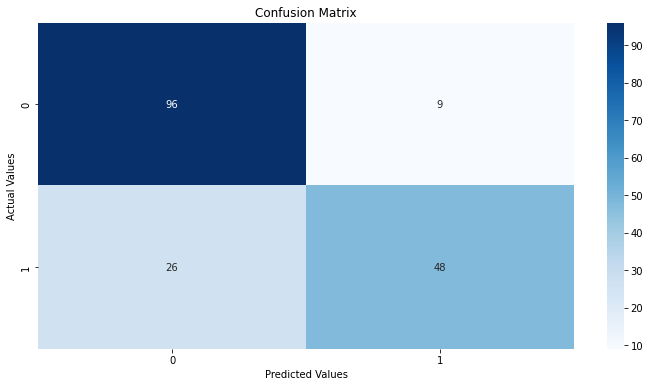

In [ ]:
cm=confusion_matrix(y_test,y_preds)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
#plt.savefig('confusion_matrix.png')

In [ ]:
clean_test_df = prep_data(test_data_kaggle)
clean_test_df

     Pclass        Age  SibSp  Parch      Fare  Female  Male  Embarked_C  \
0       3.0  34.500000    0.0    0.0    7.8292     0.0   1.0         0.0   
1       3.0  47.000000    1.0    0.0    7.0000     1.0   0.0         0.0   
2       2.0  62.000000    0.0    0.0    9.6875     0.0   1.0         0.0   
3       3.0  27.000000    0.0    0.0    8.6625     0.0   1.0         0.0   
4       3.0  22.000000    1.0    1.0   12.2875     1.0   0.0         0.0   
..      ...        ...    ...    ...       ...     ...   ...         ...   
413     3.0  25.015832    0.0    0.0    8.0500     0.0   1.0         0.0   
414     1.0  39.000000    0.0    0.0  108.9000     1.0   0.0         1.0   
415     3.0  38.500000    0.0    0.0    7.2500     0.0   1.0         0.0   
416     3.0  25.015832    0.0    0.0    8.0500     0.0   1.0         0.0   
417     3.0  23.025705    1.0    1.0   22.3583     0.0   1.0         1.0   

     Embarked_Q  Embarked_S  
0           1.0         0.0  
1           0.0         1.0

array([[1.        , 0.44736842, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.61842105, 0.125     , ..., 0.        , 0.        ,
        1.        ],
       [0.5       , 0.81578947, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.32894737, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.30263158, 0.125     , ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
pred = model.predict(clean_test_df)
predictions = (model.predict(clean_test_df) > 0.5).astype(int)

# Prepare Submission

In [ ]:
predictions

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
    

In [ ]:
submission = pd.DataFrame({
    'PassengerId': test_data_kaggle.PassengerId,
    # 'Survived': predictionsrf[:],
   'Survived': predictions[:,0],
})

submission.sort_values('PassengerId', inplace=True)    
submission.to_csv('submission.csv', index=False)